### Author: Sophie Choe

#### Portland State University, Electrical and Computer Engineering

# 4-qumode classifier

Classical layers using keras dense and quantum layers using Pennylane

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers

import pennylane as qml
import numpy as np

import matplotlib.pyplot as plt

## 0. Loading data

Normalize pixel values from 0 ~ 255 to 0 ~ 1

In [2]:
mnist = keras.datasets.mnist

# datasets are numpy.ndarrays
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()     

# normalize the image data
X_train, X_test = X_train / 255.0, X_test / 255.0

One hot encode labels to vectors of size cutoff_dim^(num_qumodes)

In [3]:
def one_hot(labels):  
       
    depth =  2**4                       # 10 classes + 6 zeros for padding
    indices = labels.astype(np.int32)    
    one_hot_labels = np.eye(depth)[indices].astype(np.float32) 
    
    return one_hot_labels

# one-hot encoded labels, each label of length cutoff dimension**2
y_train, y_test = one_hot(Y_train), one_hot(Y_test)

# using only 600 samples for training in this experiment
n_samples = 600
test_samples = 100
X_train, X_test, y_train, y_test = X_train[:n_samples], X_test[:test_samples], y_train[:n_samples], y_test[:test_samples]

## 1. Classical circuit

Define classical layers using Keras Sequential. Take in 28x28 image matrices, flatten, and output vectors of length 30. 2 hidden layers with ELU activation.

In [4]:
keras.backend.set_floatx('float32')

model = keras.models.Sequential([
                                 layers.Flatten(input_shape = (28,28)),
                                 layers.Dense(128, activation ="elu"),
                                 layers.Dense(64, activation ="elu"),
                                 layers.Dense(30),
                                ])

# More than a million parameters for the classical circuit
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1950      
Total params: 110,686
Trainable params: 110,686
Non-trainable params: 0
_________________________________________________________________


## 2. Data encoding circuit

Encode the output vectors from the classical network into quantum states using the vector entries as parameters of continuous variable gates. 

In [13]:
def encode_data(x):
    qml.Squeezing(x[0], x[1], wires=0)
    qml.Squeezing(x[2], x[3], wires=1)
    qml.Squeezing(x[4], x[5], wires=2)
    qml.Squeezing(x[6], x[7], wires=3)
    
    qml.Beamsplitter(x[8], x[9], wires=[0,1])
    qml.Beamsplitter(x[10], x[11], wires=[1,2])
    qml.Beamsplitter(x[12], x[13], wires=[2,3])
    
    qml.Rotation(x[14], wires=0)
    qml.Rotation(x[15], wires=1)
    qml.Rotation(x[16], wires=2)
    qml.Rotation(x[17], wires=3)    
    
    qml.Displacement(x[18], x[19], wires=0)
    qml.Displacement(x[20], x[21], wires=1)
    qml.Displacement(x[22], x[23], wires=2)
    qml.Displacement(x[24], x[25], wires=3) 
    
    qml.Kerr(x[26], wires=0)
    qml.Kerr(x[27], wires=1)
    qml.Kerr(x[28], wires=2)
    qml.Kerr(x[29], wires=3)

## 3. Qauntum neural network circuit

In [6]:
def qnn_layer(v):
    
    # Linear transformation W = Interferemeter, squeezers, interferometer
    # Interferometer 1
    qml.Beamsplitter(v[0], v[1], wires=[0,1])
    qml.Beamsplitter(v[2], v[3], wires=[1,2])
    qml.Beamsplitter(v[4], v[5], wires=[2,3])
    
    qml.Rotation(v[6], wires=0)
    qml.Rotation(v[7], wires=1)
    qml.Rotation(v[8], wires=2)
    qml.Rotation(v[9], wires=3)
    
    # Squeezers
    qml.Squeezing(v[10], 0.0, wires=0)
    qml.Squeezing(v[11], 0.0, wires=1)
    qml.Squeezing(v[12], 0.0, wires=2)
    qml.Squeezing(v[13], 0.0, wires=3) 
    
    # Interferometer 2
    qml.Beamsplitter(v[14], v[15], wires=[0,1])
    qml.Beamsplitter(v[16], v[17], wires=[1,2])
    qml.Beamsplitter(v[18], v[19], wires=[2,3])
    
    qml.Rotation(v[20], wires=0)
    qml.Rotation(v[21], wires=1)
    qml.Rotation(v[22], wires=2)
    qml.Rotation(v[23], wires=3)
    
    # Bias addition
    qml.Displacement(v[24], 0.0, wires=0)
    qml.Displacement(v[25], 0.0, wires=1)
    qml.Displacement(v[26], 0.0, wires=2)
    qml.Displacement(v[27], 0.0, wires=3)
    
    # Non-linear activation
    qml.Kerr(v[28], wires=0)
    qml.Kerr(v[29], wires=1)
    qml.Kerr(v[30], wires=2)
    qml.Kerr(v[31], wires=3)

## 4. Parameter initialization

Initialize parameters for the quantum layers: number of layers x number of parameters needed for all the gates

In [7]:
def init_weights(layers, modes, active_sd=0.0001, passive_sd=0.1):
    
    M = 6+4  # Number of interferometer parameters: 3 2-parameter beamsplitters + 4 rotations

    int1_weights = tf.random.normal(shape=[layers, M], stddev=passive_sd)
    s_weights = tf.random.normal(shape=[layers, modes], stddev=active_sd)
    int2_weights = tf.random.normal(shape=[layers, M], stddev=passive_sd)
    dr_weights = tf.random.normal(shape=[layers, modes], stddev=active_sd)
    k_weights = tf.random.normal(shape=[layers, modes], stddev=active_sd)

    weights = tf.concat([int1_weights, s_weights, int2_weights, dr_weights, k_weights], axis=1)
    weights = tf.Variable(weights)

    return weights

## 5. Quantum device

For the expression of qumodes in Fock basis, choose a "strawberryfields.fock" device. Define the number of qumodes and cutoff dimension. Run the data encoding circuit and quantum neural network circuit. The probability measurement method (qml.probs(wires)) returns vectors of size 2^4 = 16 (cutoff_dim^num_modes).

In [26]:
num_modes = 4
cutoff_dim = 2

# select a devide 
dev = qml.device("strawberryfields.fock", wires=num_modes, cutoff_dim=cutoff_dim) 

@qml.qnode(dev, interface="tf")
def quantum_nn(inputs, var):
    # Encode input x into quantum state
    init_layer(inputs)

    # iterative quantum layers
    for v in var:
        layer(v)

    return qml.probs(wires=[0, 1, 2, 3])  # Measurement

## 6. Hybrid circuit

In [27]:
num_layers = 4

# initialize weights for quantum layers
weights = init_weights(num_layers, num_modes)

# convert the quantum layer to a Keras layer
shape_tup = weights.shape
weight_shapes = {'var': shape_tup}
qlayer = qml.qnn.KerasLayer(quantum_nn, weight_shapes, output_dim = 4)

# add to the classical sequential model
model.add(qlayer)


## 7. Loss function and optimizer

In [29]:
opt = keras.optimizers.SGD(lr = 0.02)
model.compile(opt, loss = 'categorical_crossentropy', metrics =['accuracy'])

## 8. Training

In [11]:
hybrid = model.fit(X_train, 
                   y_train,
                   epochs = 70,
                   batch_size = 24,
                   shuffle = True, 
                   validation_data = (X_test, y_test))

Epoch 1/70
25/25 [==============================] - 3264s 133s/step - loss: 2.5297 - accuracy: 0.2474 - val_loss: 1.9022 - val_accuracy: 0.3600
Epoch 2/70
25/25 [==============================] - 2818s 113s/step - loss: 1.6432 - accuracy: 0.5106 - val_loss: 1.3988 - val_accuracy: 0.6000
Epoch 3/70
25/25 [==============================] - 2775s 111s/step - loss: 1.2322 - accuracy: 0.6732 - val_loss: 2.6377 - val_accuracy: 0.1900
Epoch 4/70
25/25 [==============================] - 2622s 106s/step - loss: 1.3326 - accuracy: 0.6144 - val_loss: 1.1969 - val_accuracy: 0.7000
Epoch 5/70
25/25 [==============================] - 6702s 267s/step - loss: 0.9805 - accuracy: 0.7499 - val_loss: 1.0918 - val_accuracy: 0.7100
Epoch 6/70
25/25 [==============================] - 3338s 137s/step - loss: 0.8674 - accuracy: 0.7841 - val_loss: 1.0537 - val_accuracy: 0.7000
Epoch 7/70
25/25 [==============================] - 1870s 75s/step - loss: 0.7672 - accuracy: 0.8335 - val_loss: 1.1539 - val_accuracy: 

In [ ]:
model.summary()

## 9. Loss and accuracy graphs

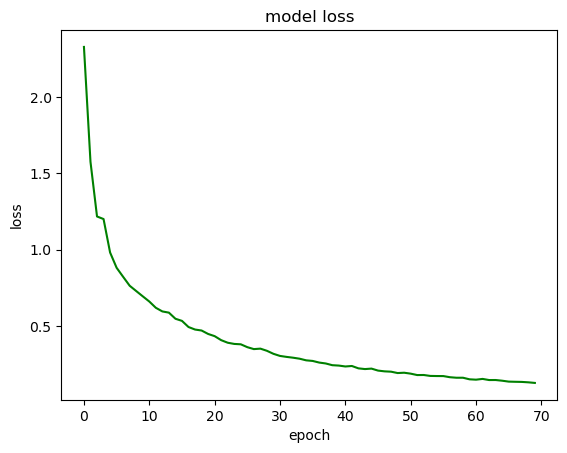

In [14]:
# ===================================================================================
#                                  Loss History Plot
# ===================================================================================

plt.title('model loss')
plt.plot(hybrid.history['loss'], '-g')
plt.ylabel('loss')
plt.show()

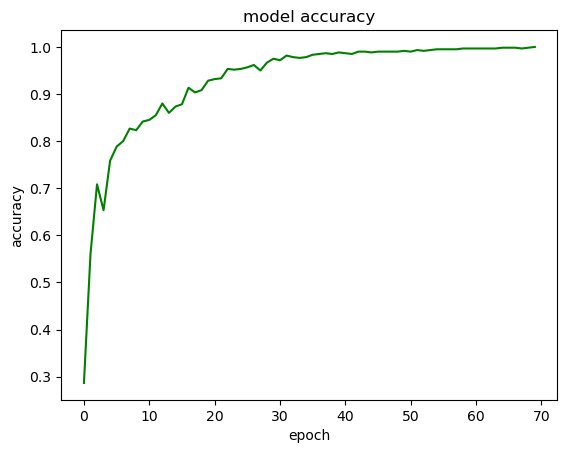

In [16]:
# ===================================================================================
#                                Accuracy History Plot
# ===================================================================================

plt.title('model accuracy')
plt.plot(hybrid.history['accuracy'], '-g')
plt.ylabel('accuracy')
plt.show()